In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import os
import copy
import itertools

In [ ]:
def set_seed(seed: int = 42) -> None:
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Random seed set as {seed}")

set_seed()

Random seed set as 42


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
folder_path = "./drive/MyDrive/ColabData/"

In [ ]:
def create_dataloaders(transform, folder_path, proportion=0.3, batch_size=64):
    image_datasets = {x: torchvision.datasets.CIFAR10(
      root=folder_path + "TrainingData",
      train=x == 'train',
      download=True,
      transform=transform
    ) for x in ['train', 'val']}

    marked_train_set = int(len(image_datasets['train']) * proportion)
    unmarked_train_set = len(image_datasets['train']) - marked_train_set

    image_datasets['marked_train'], image_datasets['unmarked_train'] = torch.utils.data.random_split(image_datasets['train'], [marked_train_set, unmarked_train_set])

    return {x: torch.utils.data.DataLoader(
        image_datasets[x], 
        batch_size=batch_size, 
    ) for x in ['marked_train', 'unmarked_train', 'val']}

In [ ]:
alexnet_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
dataloaders = create_dataloaders(alexnet_transform, folder_path)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
dataset_sizes = {x: len(dataloaders[x].dataset) for x in ['marked_train', 'unmarked_train', 'val']}
dataset_sizes

{'marked_train': 15000, 'unmarked_train': 35000, 'val': 10000}

In [ ]:
dataloaders['val'].dataset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

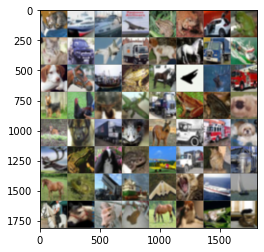

In [ ]:
def imshow(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)


inputs, classes = next(iter(dataloaders['val']))
out = torchvision.utils.make_grid(inputs)
imshow(out)

In [ ]:
reference_model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=False)
reference_model.classifier[6] = nn.Linear(4096,10)
model_teacher = copy.deepcopy(reference_model)
model_student = copy.deepcopy(reference_model)
model_teacher.to(device)
model_student.to(device)
reference_model.to(device)

Downloading: "https://github.com/pytorch/vision/zipball/v0.6.0" to /root/.cache/torch/hub/v0.6.0.zip
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
def train_model(model_student, criterion, optimizer, dataloaders_dict, model_teacher=None, num_epochs=10):
    y_loss = {phase: [] for phase in dataloaders_dict.keys()}
    y_acc = {phase: [] for phase in dataloaders_dict.keys()}

    best_acc = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        for phase in dataloaders_dict.keys():
                if 'train' in phase:
                    model_student.train()
                else:
                    model_student.eval()

                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)

                    if phase is 'unmarked_train' and model_teacher is not None:
                        teacher_outputs = model_teacher(inputs)
                        _, labels_to_use = torch.max(teacher_outputs, 1)
                    else:
                        labels_to_use = labels
                        
                    labels_to_use = labels_to_use.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled('train' in phase):
                        outputs = model_student(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels_to_use)

                        if 'train' in phase:
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels_to_use)

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                y_loss[phase].append(epoch_loss)
                y_acc[phase].append(epoch_acc.cpu().numpy())

                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model_student.state_dict())
                  
    model_student.load_state_dict(best_model_wts)
    return model_student, y_loss, y_acc

In [ ]:
def draw_graphs(y_loss, y_acc, phases, num_epochs=10):
    fig = plt.figure()
    ax0 = fig.add_subplot(121, title="loss")
    ax1 = fig.add_subplot(122, title="acc")
    x_epochs = [i + 1 for i in range(num_epochs)]

    for phase in phases:
        ax0.plot(x_epochs, y_loss[phase], label=phase)
        ax1.plot(x_epochs, y_acc[phase], label=phase)
    
    ax0.legend()
    ax1.legend()

    plt.show()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_teacher.parameters(), lr=0.01, momentum=0.9)
marked_and_val_dataloaders = dict(itertools.islice(dataloaders.items(), 0, None, 2))
model_teacher, y_loss, y_acc = train_model(model_teacher, criterion, optimizer, marked_and_val_dataloaders)

Epoch 1/10
----------
marked_train Loss: 2.2174 Acc: 0.1580
val Loss: 2.0655 Acc: 0.2403
Epoch 2/10
----------
marked_train Loss: 1.9016 Acc: 0.2953
val Loss: 1.7097 Acc: 0.3655
Epoch 3/10
----------
marked_train Loss: 1.6257 Acc: 0.4071
val Loss: 1.5291 Acc: 0.4420
Epoch 4/10
----------
marked_train Loss: 1.4459 Acc: 0.4711
val Loss: 1.3841 Acc: 0.4972
Epoch 5/10
----------
marked_train Loss: 1.3032 Acc: 0.5260
val Loss: 1.2525 Acc: 0.5582
Epoch 6/10
----------
marked_train Loss: 1.1646 Acc: 0.5828
val Loss: 1.1830 Acc: 0.5790
Epoch 7/10
----------
marked_train Loss: 1.0556 Acc: 0.6255
val Loss: 1.0713 Acc: 0.6236
Epoch 8/10
----------
marked_train Loss: 0.9341 Acc: 0.6729
val Loss: 0.9925 Acc: 0.6534
Epoch 9/10
----------
marked_train Loss: 0.8547 Acc: 0.6961
val Loss: 1.0298 Acc: 0.6471
Epoch 10/10
----------
marked_train Loss: 0.7719 Acc: 0.7294
val Loss: 0.9929 Acc: 0.6722


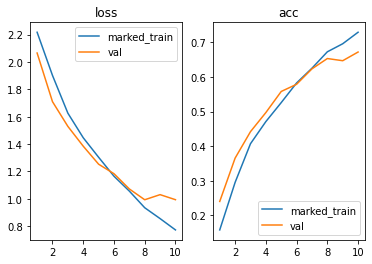

In [ ]:
draw_graphs(y_loss, y_acc, y_loss.keys())

In [ ]:
torch.save(model_teacher.state_dict(), folder_path + 'ModelWeights/model_teacher_weights.pth')

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_student.parameters(), lr=0.01, momentum=0.9)
model_student, y_loss, y_acc = train_model(model_student, criterion, optimizer, dataloaders, model_teacher=model_teacher)

Epoch 1/10
----------
marked_train Loss: 2.2149 Acc: 0.1611
unmarked_train Loss: 1.5497 Acc: 0.4369
val Loss: 1.5728 Acc: 0.4599
Epoch 2/10
----------
marked_train Loss: 1.3458 Acc: 0.5157
unmarked_train Loss: 0.8823 Acc: 0.6804
val Loss: 1.3838 Acc: 0.5750
Epoch 3/10
----------
marked_train Loss: 1.0300 Acc: 0.6400
unmarked_train Loss: 0.6643 Acc: 0.7567
val Loss: 1.3415 Acc: 0.6229
Epoch 4/10
----------
marked_train Loss: 0.8844 Acc: 0.6916
unmarked_train Loss: 0.5629 Acc: 0.7945
val Loss: 1.3728 Acc: 0.6395
Epoch 5/10
----------
marked_train Loss: 0.7975 Acc: 0.7223
unmarked_train Loss: 0.4853 Acc: 0.8212
val Loss: 1.4158 Acc: 0.6328
Epoch 6/10
----------
marked_train Loss: 0.7271 Acc: 0.7493
unmarked_train Loss: 0.4432 Acc: 0.8364
val Loss: 1.4644 Acc: 0.6507
Epoch 7/10
----------
marked_train Loss: 0.6563 Acc: 0.7730
unmarked_train Loss: 0.4014 Acc: 0.8545
val Loss: 1.3260 Acc: 0.6629
Epoch 8/10
----------
marked_train Loss: 0.5902 Acc: 0.7949
unmarked_train Loss: 0.3639 Acc: 0.86

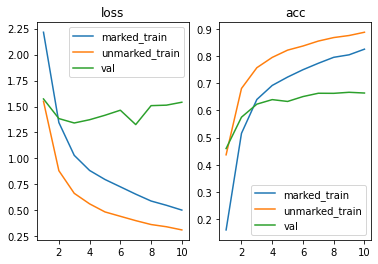

In [ ]:
draw_graphs(y_loss, y_acc, y_loss.keys())

In [ ]:
torch.save(model_student.state_dict(), folder_path + 'ModelWeights/model_student_weights.pth')

In [ ]:
def visualize_acc_preds(model, dataloader, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    correct = 0
    total = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            print(f'Accuracy of the network on the 10000 test images: {int(100 * correct / total)} %\n')

            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {dataloader.dataset.classes[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return

        model.train(mode=was_training)

Accuracy of the network on the 10000 test images: 67 %



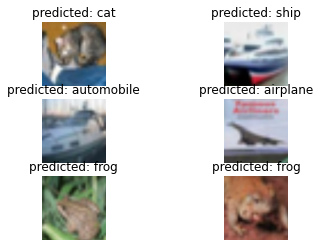

In [ ]:
visualize_acc_preds(model_student, dataloaders['val'])